In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt
from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import SeasonalAD

## TASK

The exercise is based on a data set derived from a Free Flowing Natural Gas Well.

Please look at the data description, the variable names and definitions are available.

The task is divided in three parts:

1. Find a programmatic way to label the events in the dataset

2. Fit a model to the labeled dataset (if you decide to use the sample model please make at least one enhancement of substantial modification)

3. Perform a complete evaluation of the results (performance metric)

## EDA

In [3]:
d = pd.read_excel('CANDY CANE 101 - CLASS.xlsx')
d.head()

,Type of Facility,Name of Facility,Timestamp,"Wellhead Casing ""A"" - Pressure","Wellhead Casing ""B"" - Pressure",Flowline Pressure,Flowline Temperature,Volume - Calendar Day Production,Wellhead Tubing - Pressure
0,Synthetic Data,CANDY CANE WELL 101,2017-08-24 16:58:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
1,Synthetic Data,CANDY CANE WELL 101,2017-08-24 16:59:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
2,Synthetic Data,CANDY CANE WELL 101,2017-08-24 17:00:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
3,Synthetic Data,CANDY CANE WELL 101,2017-08-24 17:01:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data
4,Synthetic Data,CANDY CANE WELL 101,2017-08-24 17:02:00,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data,No Available Data


In [4]:
d.shape

(422378, 9)

In [5]:
#checking if 1st, 2nd column have the same values
print(d['Type of Facility'].unique(), d['Name of Facility'].unique())

['Synthetic Data '] ['CANDY CANE WELL 101']


In [6]:
def MV_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [7]:
#missing values
MV_table(d)

Dataframe has 9 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
"Wellhead Casing ""B"" - Pressure",422314,100.0


In [8]:
#drop unimportant columns
df = d.drop(['Type of Facility','Name of Facility'], axis=1)

Renaming columns:

Wellhead Casing "A" - Pressure -> PCAS -> PA

Wellhead Casing "B" - Pressure -> PAVTUBY -> PB

Flowline Pressure -> PLN -> FLP

Flowline Temperature -> TG -> FLT

Volume - Calendar Day Production -> FG -> V

Wellhead Tubing - Pressure -> PTUB -> WTP

In [9]:
#rename columns
df.columns = ['Timestamp', 'PA', 'PB', 'FLP', 'FLT', 'V', 'WTP']
#Convert timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [10]:
#replacing 'No available data' with NaN
df = df.replace({'No Available Data': np.nan})

In [11]:
#check df on NA
print(df.isna().sum(), '/n', 100 * df.isna().sum()/ len(df))

Timestamp         0
PA               64
PB           422378
FLP              64
FLT              65
V                64
WTP              64
dtype: int64 /n Timestamp      0.000000
PA             0.015152
PB           100.000000
FLP            0.015152
FLT            0.015389
V              0.015152
WTP            0.015152
dtype: float64


In [12]:
#converting to float type
df['PA'] = pd.to_numeric(df['PA'], errors='coerce').astype(float)
df['PB'] = pd.to_numeric(df['PB'], errors='coerce').astype(float)
df['FLP'] = pd.to_numeric(df['FLP'], errors='coerce').astype(float)
df['FLT'] = pd.to_numeric(df['FLT'], errors='coerce').astype(float)
df['V'] = pd.to_numeric(df['V'], errors='coerce').astype(float)
df['WTP'] = pd.to_numeric(df['WTP'], errors='coerce').astype(float)

#fillin missing values with average values fro each column
df['PA'] = df['PA'].fillna(df['PA'].mean())
df['FLP'] = df['FLP'].fillna(df['FLP'].mean())
df['FLT'] = df['FLT'].fillna(df['FLT'].mean())
df['V']  = df['V'] .fillna(df['V'] .mean())
df['WTP']= df['WTP'].fillna(df['WTP'].mean())

#for PAVTUBY 100% data is missing, we create values for it with moving average of PCAS for 2 days and filling Na for PAVTUBY
df['PB'] = df['PB'].fillna(df['WTP'].rolling(window = 2880).mean())
df['PB'] = df['PB'].fillna(df['PB'].mean())

In [13]:
#filtering data based on Timestamp column since 2017 has missing values
df = df[df['Timestamp'].dt.year >= 2018]

In [14]:
df.shape

(236196, 7)

In [15]:
df.describe()

,PA,PB,FLP,FLT,V,WTP
count,236196.000000,236196.000000,236196.000000,236196.000000,236196.000000,236196.000000
mean,1739.257338,918.585306,583.780216,59.960713,7300.280017,917.848071
std,211.624016,176.872046,67.816372,15.947502,1278.370805,225.268082
min,736.114929,698.697026,-0.436380,9.102852,0.000000,681.901367
25%,1592.780640,816.851298,536.243225,48.897324,6807.213867,812.288391
50%,1705.325317,854.677448,560.508301,56.587185,7400.516113,841.567047
75%,1858.129639,1005.617618,639.633728,67.018227,7882.259277,993.915283
max,5138.380371,1592.604910,1375.019043,132.943359,11657.337891,2421.081543


In [15]:
#correlation for numerical columns
df.drop(['Timestamp'], axis = 1).corr()

,PA,PB,FLP,FLT,V,WTP
PA,1.000000,0.592904,0.489532,0.080106,0.282188,0.489895
PB,0.592904,1.000000,0.603286,0.156228,0.407771,0.712522
FLP,0.489532,0.603286,1.000000,0.141852,0.408523,0.468049
FLT,0.080106,0.156228,0.141852,1.000000,0.176761,0.002768
V,0.282188,0.407771,0.408523,0.176761,1.000000,-0.159235
WTP,0.489895,0.712522,0.468049,0.002768,-0.159235,1.000000


higher 0.5: PA and PB, PB and FLP, PB and WTP

neg: v and WTP

In [20]:
#reorder columns, volume - the last one
df = df[['Timestamp','PA', 'PB', 'FLP', 'FLT', 'WTP', 'V']]

In [21]:
#extract month and day for boxplots
df_t = df.set_index('Timestamp')
df_t['Month'] = df_t.index.month
df_t['Day'] = df_t.index.weekday_name
df_t.head()

,PA,PB,FLP,FLT,WTP,V,Month,Day
Timestamp,,,,,,,,
2018-01-01 00:00:00,2070.508057,1326.526569,648.307800,41.032509,1271.876099,8538.653320,1,Monday
2018-01-01 00:01:00,2070.637695,1326.473592,667.404175,41.602646,1271.616821,8496.515625,1,Monday
2018-01-01 00:02:00,2070.637695,1326.420614,667.404175,41.602646,1271.616821,8496.515625,1,Monday
2018-01-01 00:03:00,2070.637695,1326.367636,667.404175,41.602646,1271.616821,8496.515625,1,Monday
2018-01-01 00:04:00,2070.637695,1326.314659,667.404175,41.602646,1271.616821,8496.515625,1,Monday


In [22]:
#Disable iPython Notebook Autoscrolling
#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999

Text(0.5, 1.0, 'WTP')

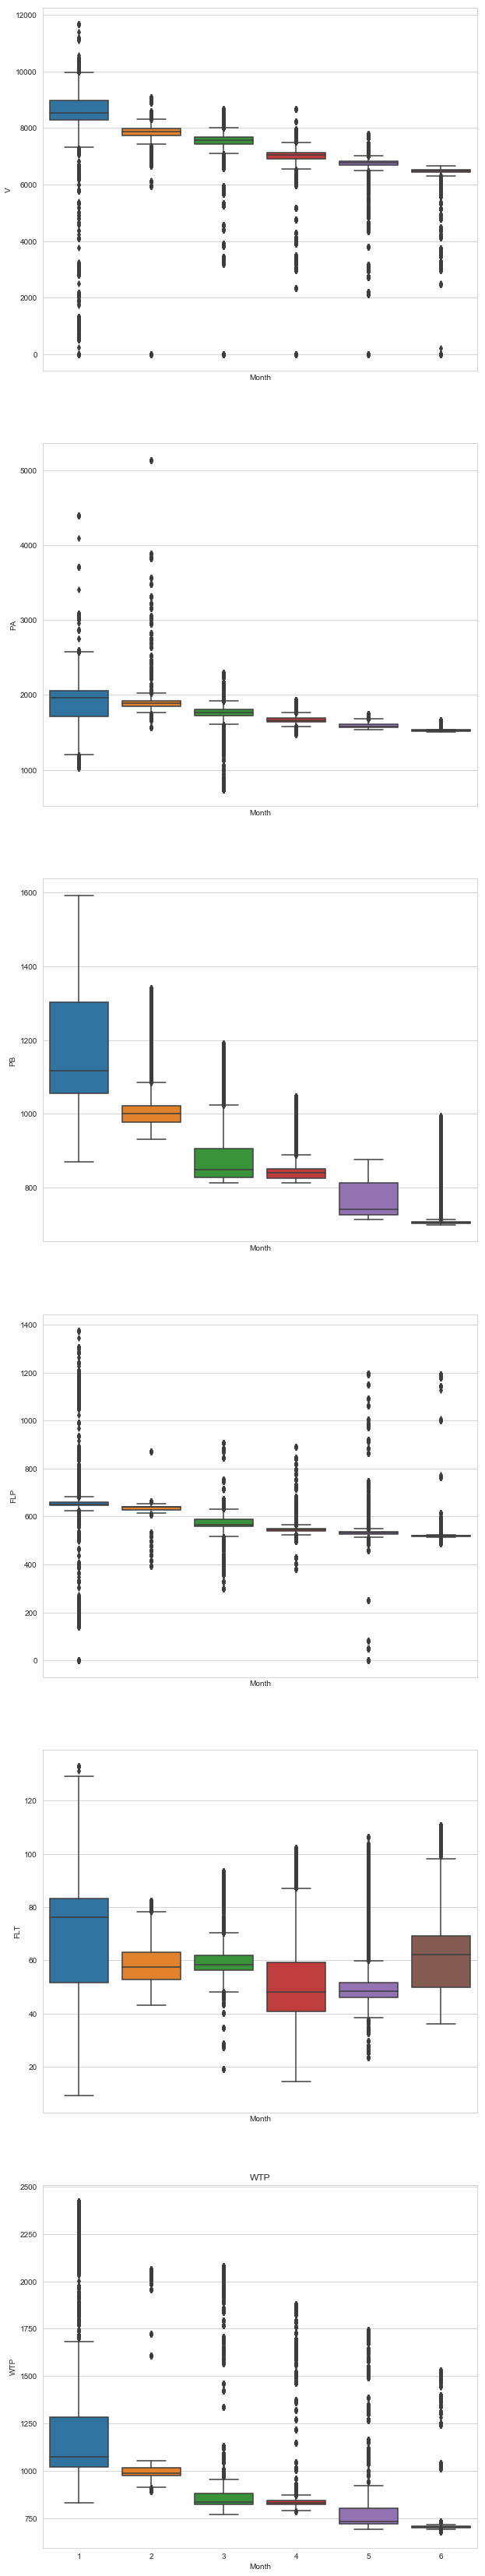

In [23]:
fig, axes = plt.subplots(6, 1, figsize=(10, 60), sharex=True)
sns.set_style('whitegrid')
for name, ax in zip(['V', 'PA', 'PB', 'FLP', 'FLT', 'WTP'], axes):
    sns.boxplot(data=df_t, x='Month', y=name, ax=ax)
ax.set_title(name)

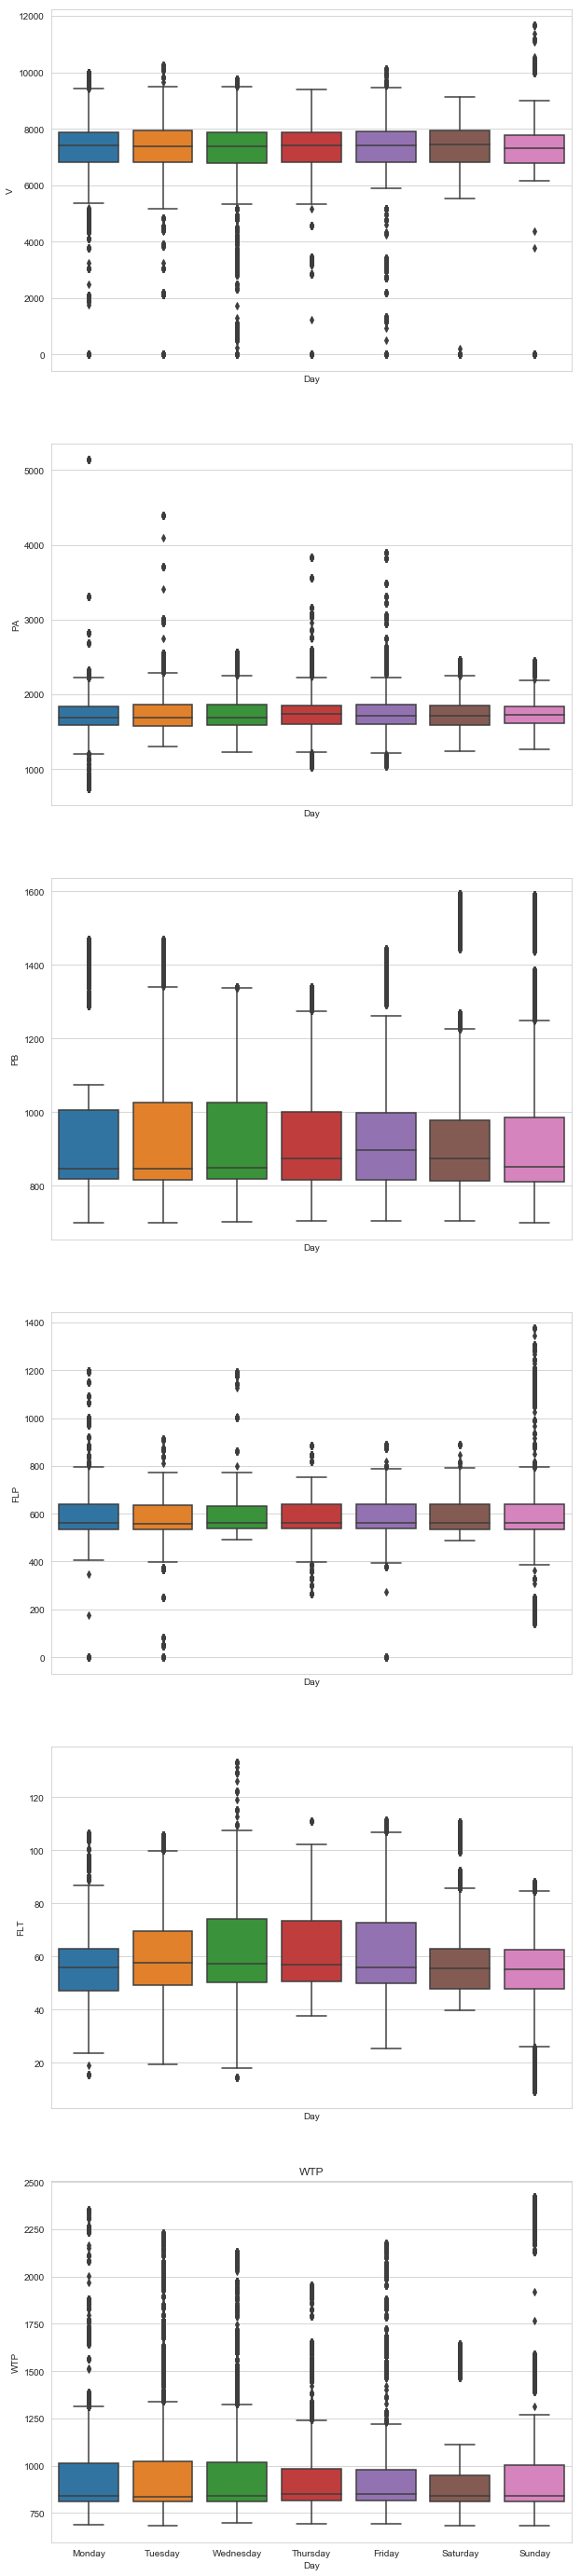

In [24]:
fig, axes = plt.subplots(6, 1, figsize=(10, 50), sharex=True)
sns.set_style('whitegrid')
for name, ax in zip(['V', 'PA', 'PB', 'FLP', 'FLT', 'WTP'], axes):
    sns.boxplot(data=df_t, x='Day', y=name, ax=ax)
ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

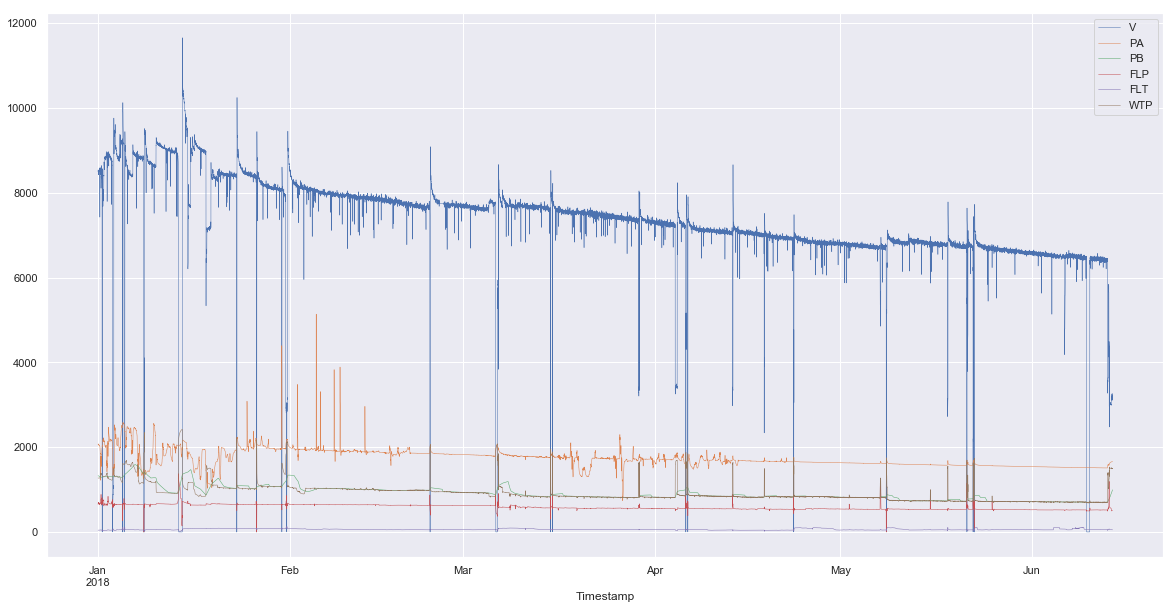

In [25]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t[['V', 'PA', 'PB', 'FLP', 'FLT', 'WTP']].plot(linewidth=0.5)

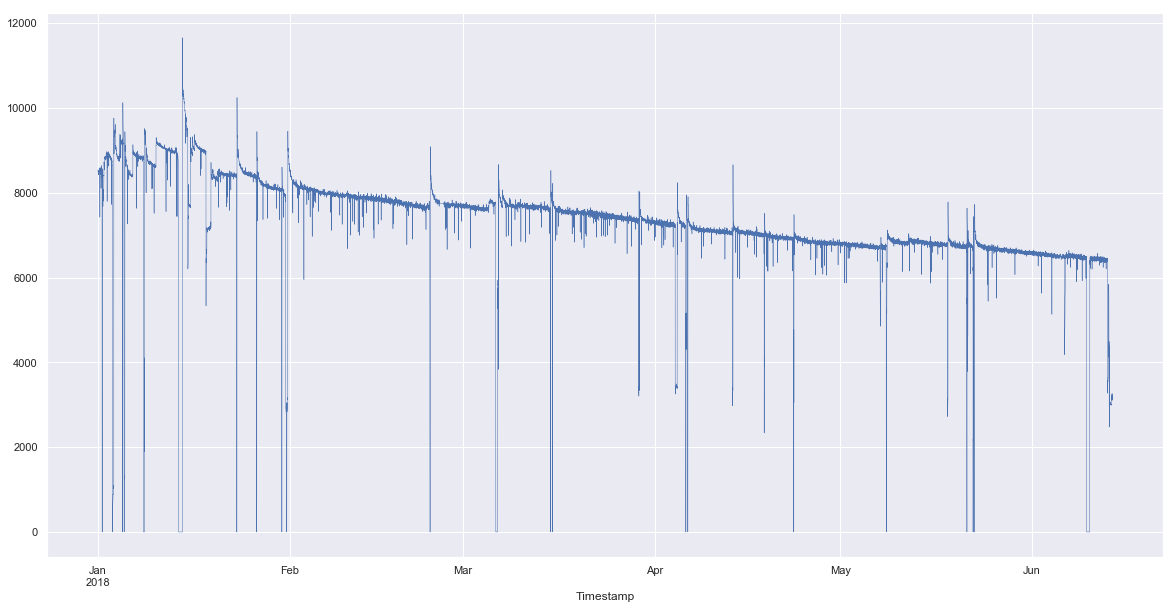

In [26]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t['V'].plot(linewidth=0.5)

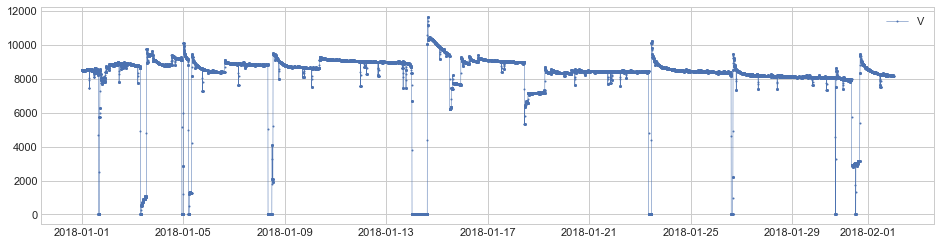

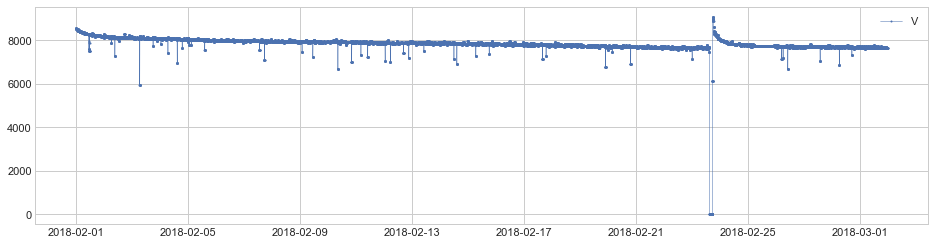

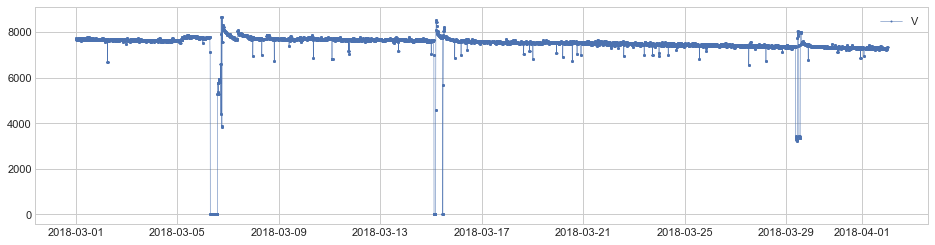

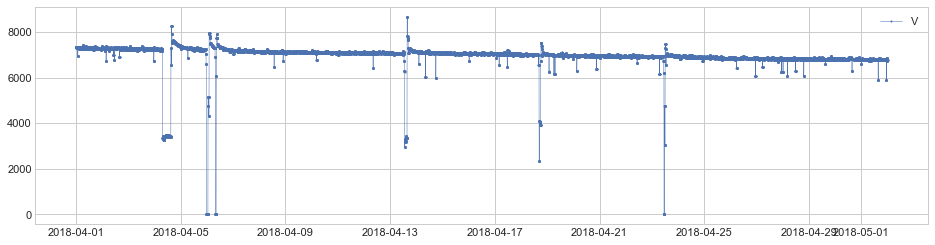

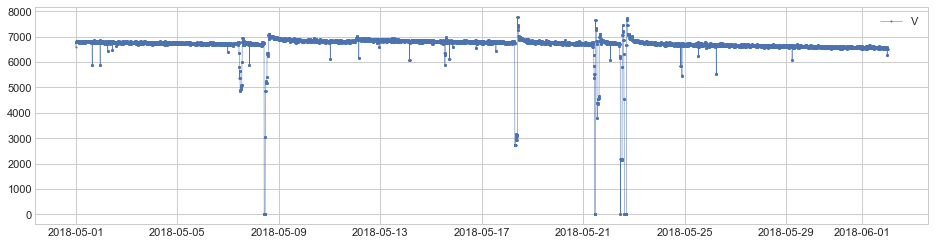

In [29]:
#zoom 'volume' montly
plot(df_t['V'].loc['2018-01-01':'2018-02-01'])
plot(df_t['V'].loc['2018-02-01':'2018-03-01'])
plot(df_t['V'].loc['2018-03-01':'2018-04-01'])
plot(df_t['V'].loc['2018-04-01':'2018-05-01'])
plot(df_t['V'].loc['2018-05-01':'2018-06-01'])

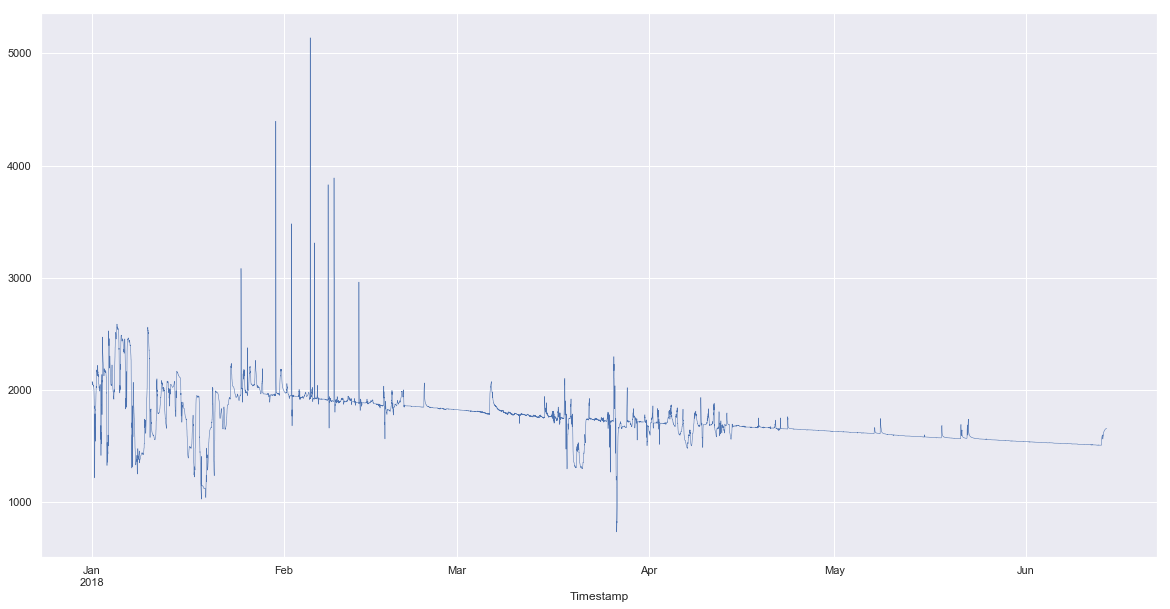

In [30]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t['PA'].plot(linewidth=0.5)

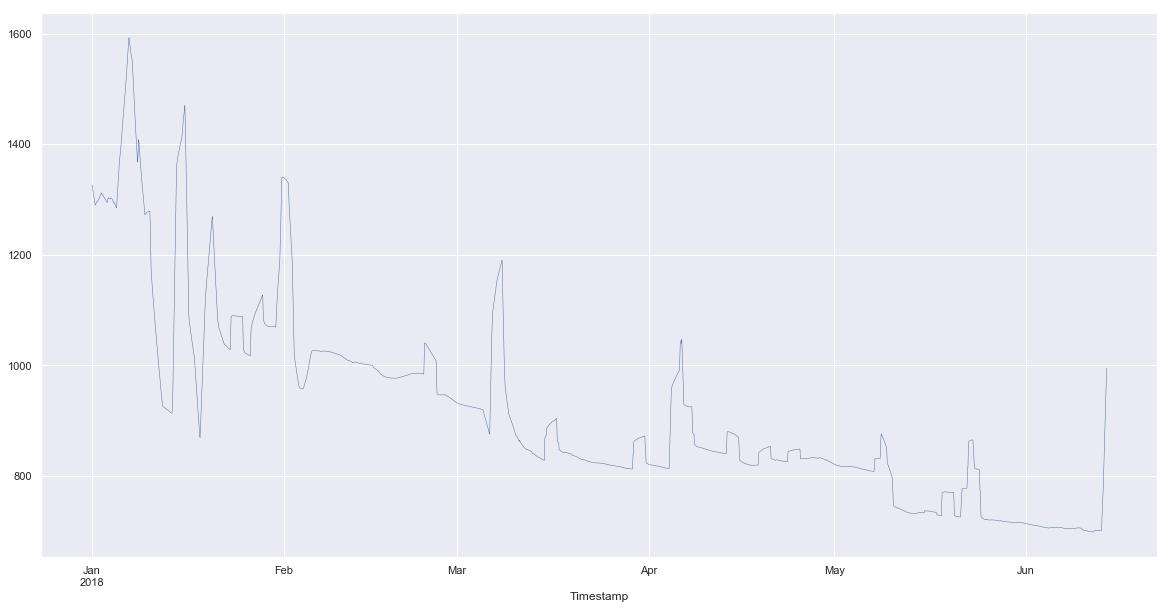

In [31]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t['PB'].plot(linewidth=0.5)

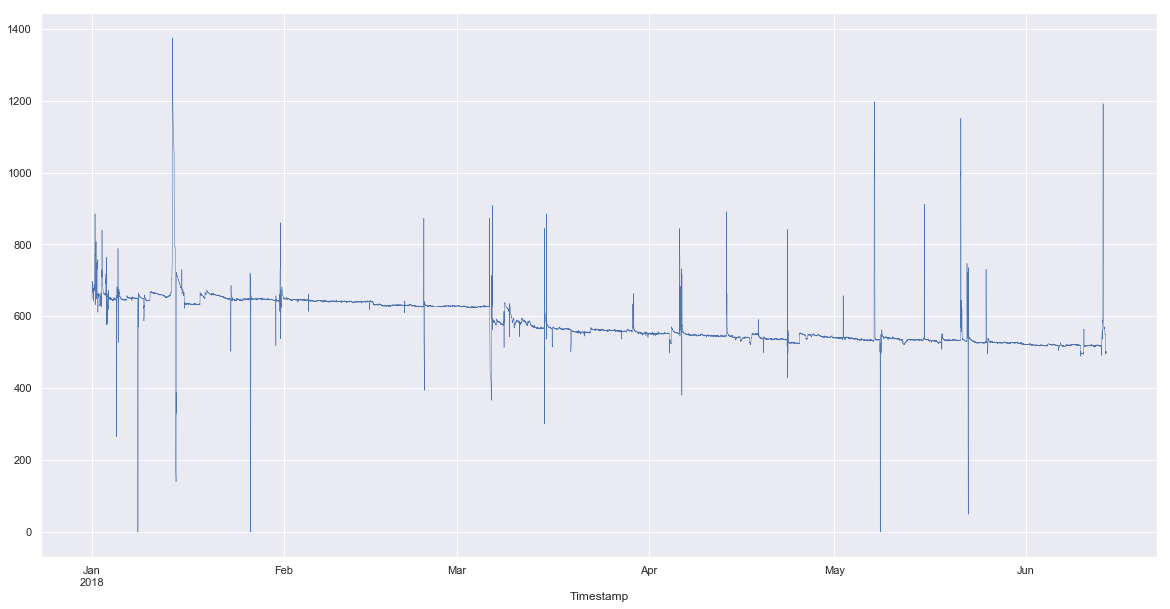

In [32]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t['FLP'].plot(linewidth=0.5)

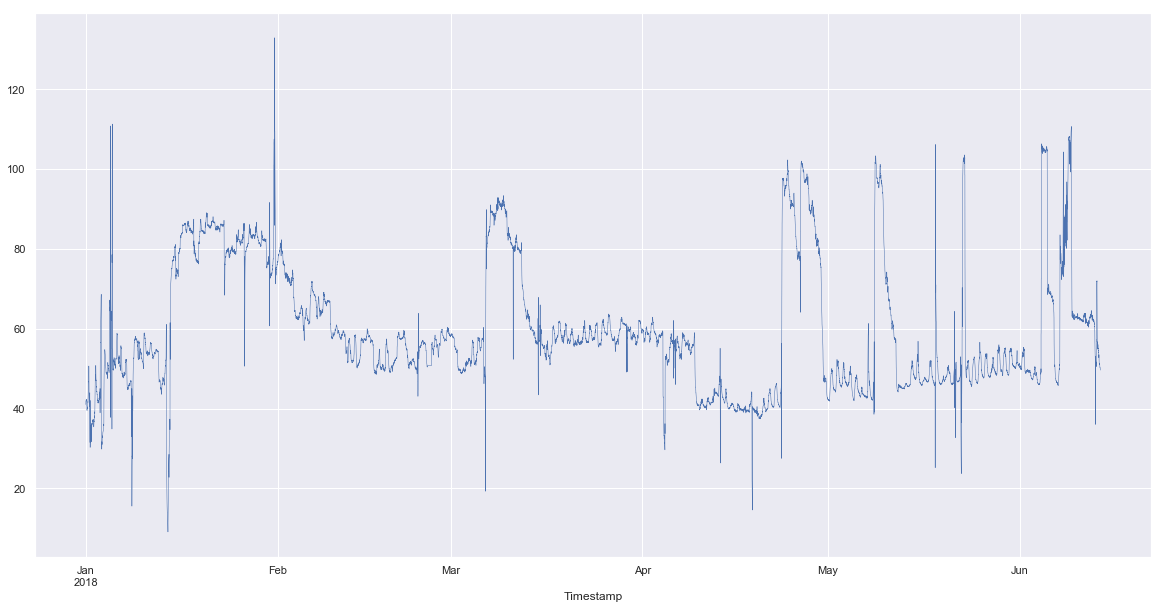

In [33]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t['FLT'].plot(linewidth=0.5)

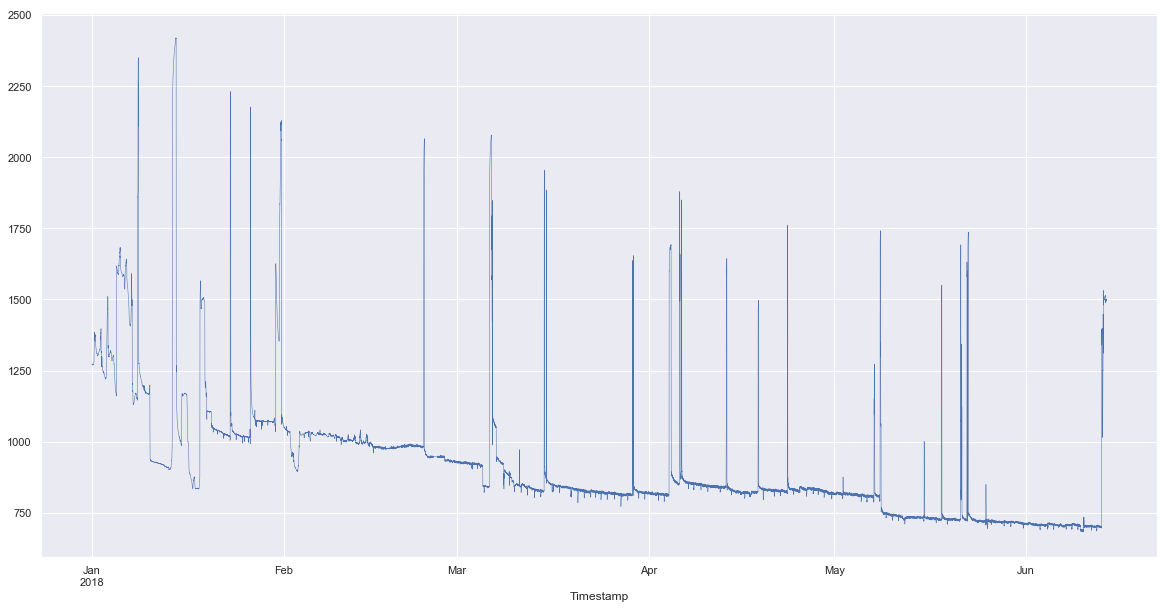

In [34]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t['WTP'].plot(linewidth=0.5)

## LABELING

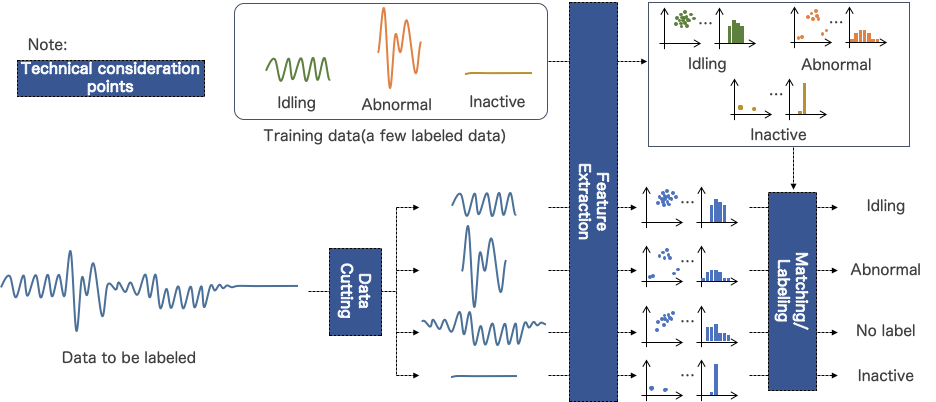

1. PM(Preventative Maintenance) - output become zero and stays zero for some time(find beginning and end of this cases)
2. US(Unexpected Shutdown) - output drops suddenly and recovers
3. SE(Sensor Errors) - negative trends associated with power failures in facility

1)Load the data in Python and do some cleaning

2)Plot the data and analyze the plot. PM vs US

3)Based on this analysis label the dataset (one more column) PM = 1 otherwise = 0 ***

4)Exclude the PM events from the training and evaluation of the model.

5)Using the same univariate technique or adding a covariate 
or explanatory variable and make the LSTM multivariate (do not use more than 2 in favor of computational efficiency). 

NOTES: to keep the LSTM light you can lower the number of epoc’s, increase batch size
Use elastic regression to predict Use a blend or classic Time Series and LSTM to predict

In [ ]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#from matplotlib import pyplot
#result = seasonal_decompose(df['V'], model='additive')
#result.plot()
#pyplot.show()

## TSAUG /Time Series Augmentation/

In [ ]:
#!pip install tsaug
#X = df_t['Month']
#Y = df_t['FG']
#from tsaug import random_time_warp
#X_aug, Y_aug = random_time_warp(X, Y)
#plot(X_aug, Y_aug)

## FBprophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, 
weekly, and daily seasonality, plus holiday effects. 
It works best with time series that have strong seasonal effects and several seasons of historical data. 
Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
#!pip install pystan
#!pip install --user fbprophet

In [ ]:
#from fbprophet import Prophet

## ADTK /Anomaly Detection Toolkit/

In [35]:
#!pip install adtk

In [61]:
#Could not find significant seasonality: V and FLT

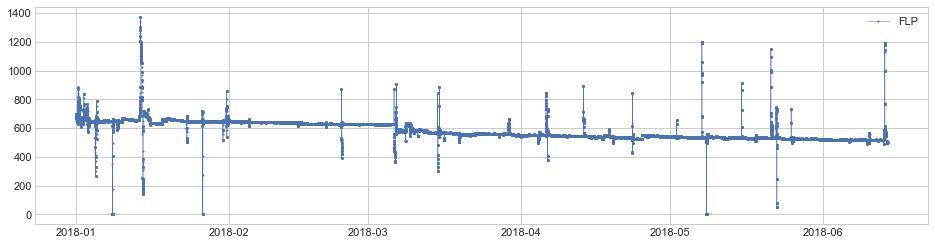

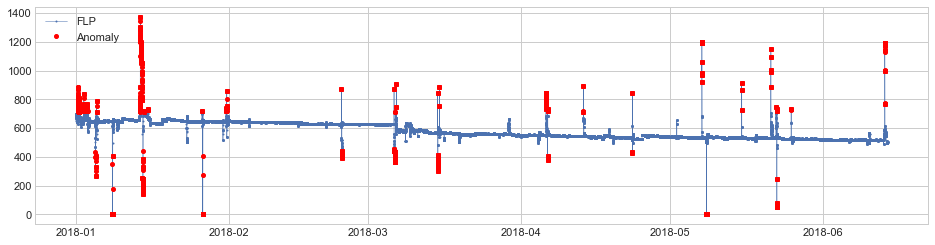

In [35]:
#flowline pressure
s_train1 = df_t['FLP']
s_train1 = validate_series(s_train1)
#print(s_train)
plot(s_train1)

seasonal_ad1 = SeasonalAD()
anomalies1 = seasonal_ad1.fit_detect(s_train1)
plot(s_train1, anomaly=anomalies1, anomaly_color="red", anomaly_tag="marker")

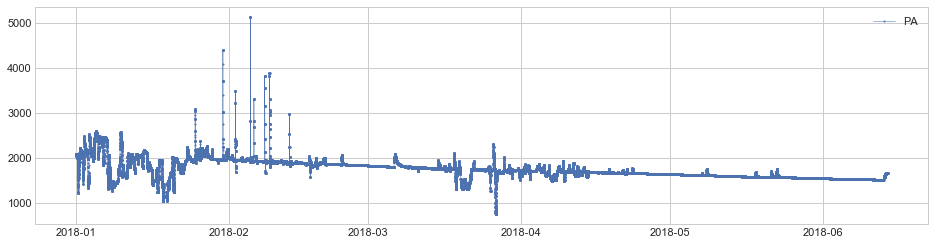

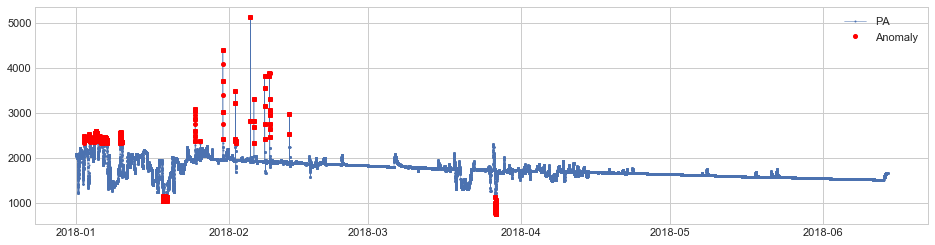

In [36]:
#Wellhead Casing "A" - Pressure
s_train2 = df_t['PA']
s_train2 = validate_series(s_train2)
plot(s_train2)

seasonal_ad2 = SeasonalAD()
anomalies2 = seasonal_ad2.fit_detect(s_train2)
plot(s_train2, anomaly=anomalies2, anomaly_color="red", anomaly_tag="marker")

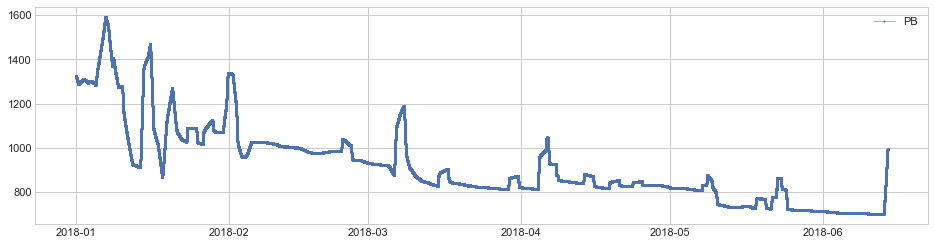

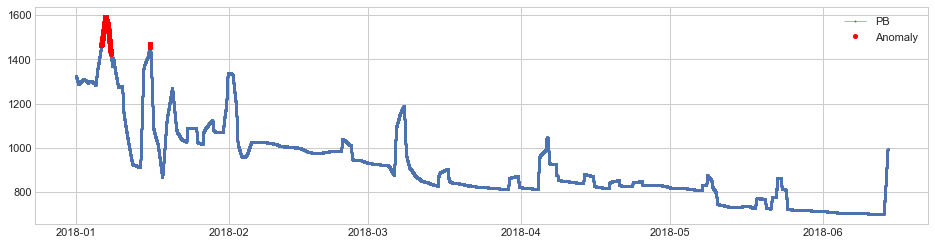

In [37]:
#Wellhead Casing "B" - Pressure
s_train3 = df_t['PB']
s_train3 = validate_series(s_train3)
plot(s_train3)

seasonal_ad3 = SeasonalAD()
anomalies3 = seasonal_ad3.fit_detect(s_train3)
plot(s_train3, anomaly=anomalies3, anomaly_color="red", anomaly_tag="marker")

## We`re planning to keep 'anomalies' for B-pressure, when analyzing boxplots for B-pressure it doesnt seem to be anomalies 

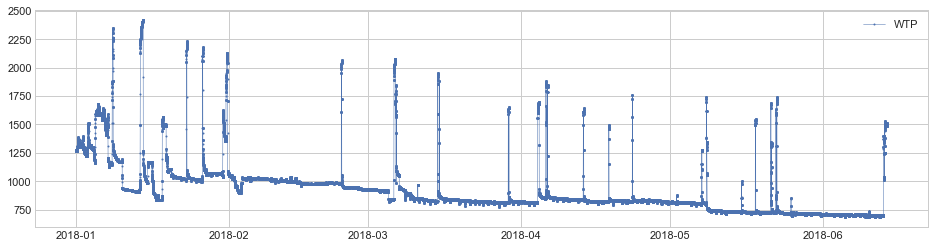

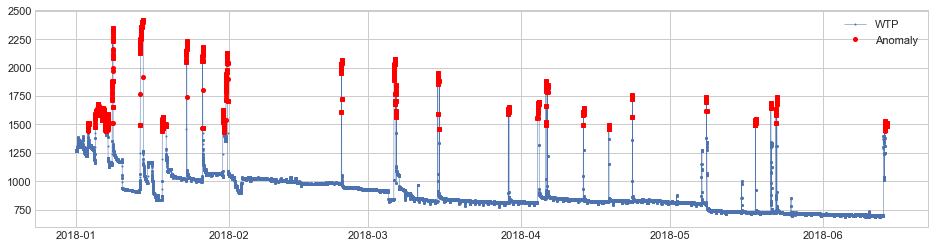

In [41]:
#Wellhead Tubing - Pressure
s_train4 = df_t['WTP']
s_train4 = validate_series(s_train4)
plot(s_train4)

seasonal_ad4 = SeasonalAD()
anomalies4 = seasonal_ad4.fit_detect(s_train4)
plot(s_train4, anomaly=anomalies4, anomaly_color="red", anomaly_tag="marker")

In [ ]:
##Flowline temperature Feb
s_train52 = df_t['FLT'].loc['2018-02-21':'2018-02-25']
s_train52 = validate_series(s_train52)
plot(s_train52)

seasonal_ad52 = SeasonalAD()
anomalies52 = seasonal_ad52.fit_detect(s_train52)
plot(s_train52, anomaly=anomalies52, anomaly_color="red", anomaly_tag="marker")

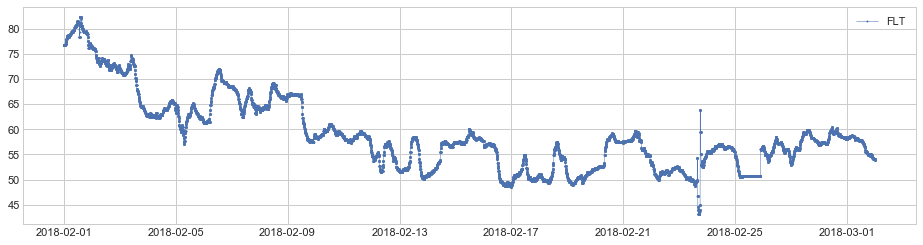

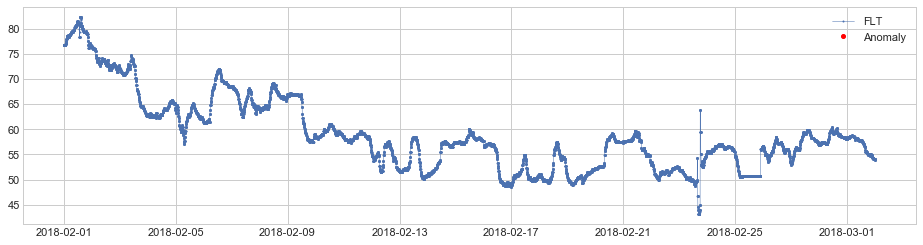

In [45]:
##Flowline temperature Feb
s_train5 = df_t['FLT'].loc['2018-02-01':'2018-03-01']
s_train5 = validate_series(s_train5)
plot(s_train5)

seasonal_ad5 = SeasonalAD()
anomalies5 = seasonal_ad5.fit_detect(s_train5)
plot(s_train5, anomaly=anomalies5, anomaly_color="red", anomaly_tag="marker")

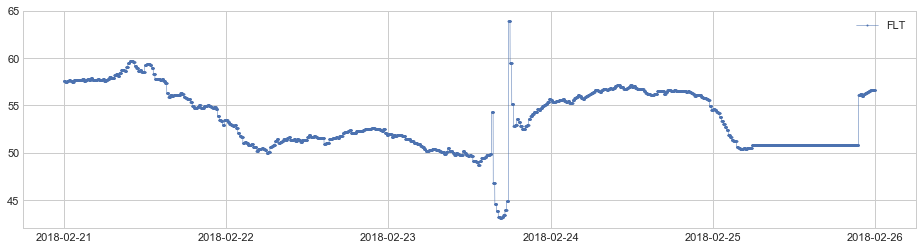

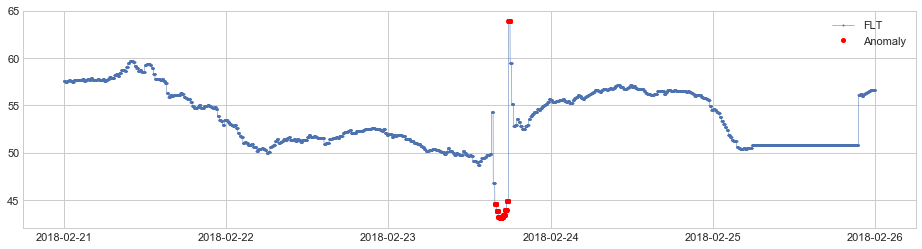

In [50]:
##Flowline temperature Feb
s_train52 = df_t['FLT'].loc['2018-02-21':'2018-02-25']
s_train52 = validate_series(s_train52)
plot(s_train52)

seasonal_ad52 = SeasonalAD()
anomalies52 = seasonal_ad52.fit_detect(s_train52)
plot(s_train52, anomaly=anomalies52, anomaly_color="red", anomaly_tag="marker")

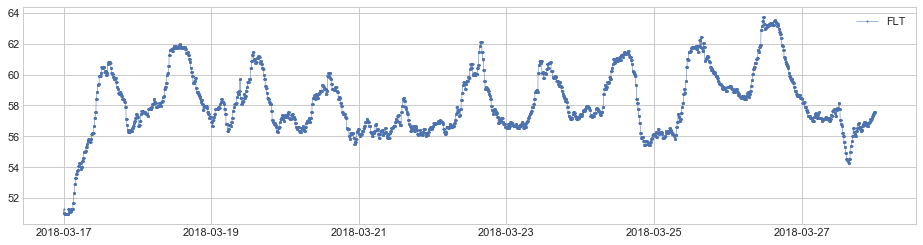

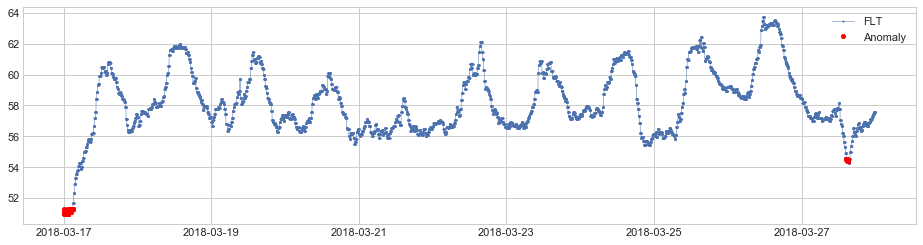

In [49]:
#Flowline temperature march 17-27
s_train51 = df_t['FLT'].loc['2018-03-17':'2018-03-27']
s_train51 = validate_series(s_train51)
plot(s_train51)

seasonal_ad51 = SeasonalAD()
anomalies51 = seasonal_ad51.fit_detect(s_train51)
plot(s_train51, anomaly=anomalies51, anomaly_color="red", anomaly_tag="marker")

In [110]:
#store anomalies as columns to fiter later
df_t['A1'] = anomalies1
df_t['A2'] = anomalies2
#df_t['A3'] = anomalies3 keep for B-pressure
df_t['A4'] = anomalies4

In [111]:
#PM
df_t['PM'] = np.where(df_t['V'] == 0, 1, 0)
#df[df['PM']==1].shape
#df[df['PM']==0].shape

## Filtering?


In [112]:
#data_pm - drop anomalies and keep pm, data_woutpm - drop animalies and without pm
data_pm = df_t[(df_t.A1 == False) & (df_t.A2 == False) & (df_t.A4 == False) & (df_t.PM == 1)]
data_wout_pm = df_t[(df_t.A1 == False) & (df_t.A2 == False) & (df_t.A3 == False) & (df_t.A4 == False) & (df_t.PM == 0)]
print(data_pm.shape, data_wout_pm.shape)

(792, 13) (220025, 13)


In [113]:
#drop not important columns
data_wout_pm = data_wout_pm.drop(['Month', 'Day', 'A1','A2','A3','A4','PM'], axis=1)

In [114]:
#filter Volume column. Drop values less than 6000
df_clean = data_wout_pm[data_wout_pm['V'] > 6000]

In [115]:
df_clean.shape

(218865, 6)

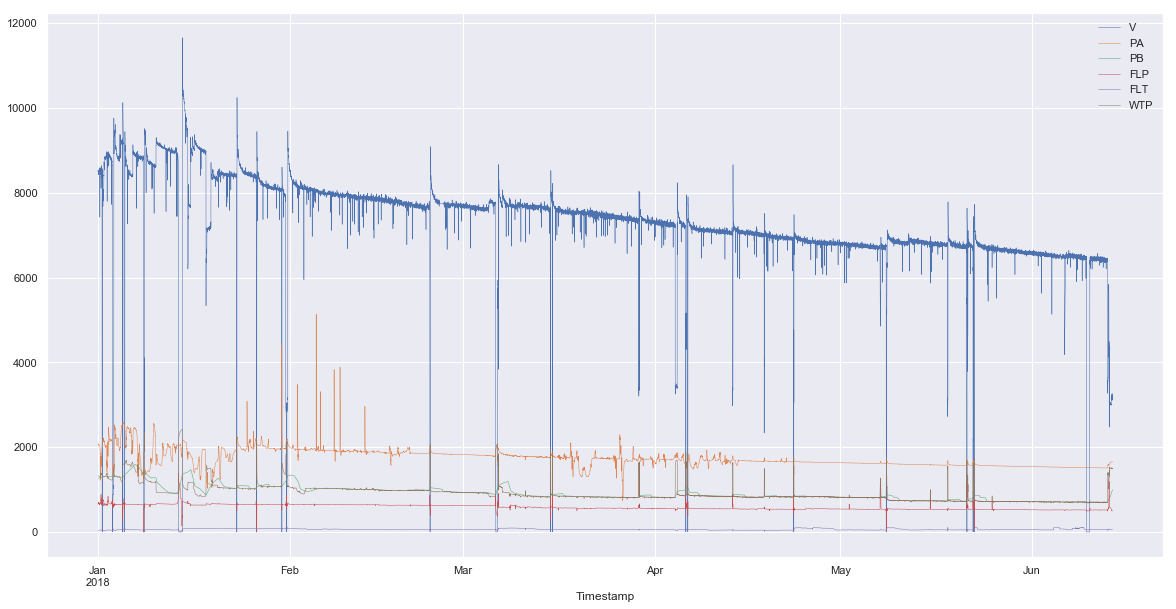

In [116]:
sns.set(rc={'figure.figsize':(20, 10)})
df_t[['V', 'PA', 'PB', 'FLP', 'FLT', 'WTP']].plot(linewidth=0.5)

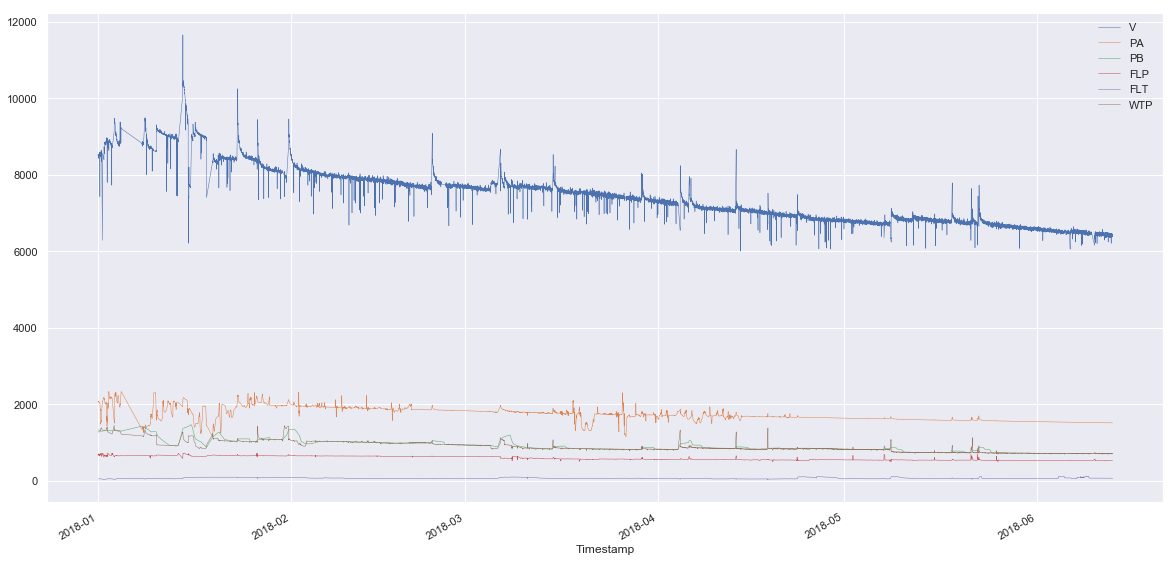

In [117]:
sns.set(rc={'figure.figsize':(20, 10)})
df_clean[['V', 'PA', 'PB', 'FLP', 'FLT', 'WTP']].plot(linewidth=0.5)

In [118]:
#save to new file
df_clean.to_csv('clean_candy.csv', index = True)